# Analysis of SEIRX model runs for test technology and screening frequency

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import analysis_functions as af

### Mappings of variables to nicer labels for plots

In [3]:
frequency_name_map = {np.nan:'never',
              2:'3 times\na week',
              3:'twice\na week',
              7:'once\na week'}

test_name_map = {'same_day_antigen':'same-day antigen', 'one_day_PCR':'one day PCR',
             'two_day_PCR':'two days PCR', 'same_day_PCR':'same-day PCR',
             'same_day_LAMP':'same-day RT-LAMP'}

metric_name_map = {'infected_residents_mean':'follow-up cases residents (mean)',
                   'infected_residents_median':'follow-up cases residends (median)',
                   'infected_residents_0.90':'follow-up cases residents (90th percentile)',
                   'R0_mean':'$R_0$',
                   'R0_mean':'$R_0$'}

index_case_map = {'employee':'index case employee',
                  'resident':'index case resident'}

screening_intervals = ['never', 'once\na week', 'twice\na week', '3 times\na week']

### Data loading and wrangling

In [4]:
res_path = '../data/simulation_results'
dst_path = '../plots/'
sim_name = 'simulations_testing_strategy'
N_runs = 5000
data = pd.read_csv(join(res_path,'{}_{}.csv'.format(sim_name, N_runs)))

In [5]:
# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

# set screen intervals, test types and index case as categorical variables with
# explicit order, to facilitate sorting in a nicer way
data['resident_screen_interval'] = pd.Categorical(data['resident_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['employee_screen_interval'] = pd.Categorical(data['employee_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['test_type'] = pd.Categorical(data['test_type'], 
    categories=['same_day_antigen', 'same_day_LAMP', 'same_day_PCR', 'one_day_PCR',  
                'two_day_PCR',], ordered=True)

data['index_case'] = pd.Categorical(data['index_case'], 
    categories=['employee', 'resident'], ordered=True)

data = data.sort_values(by=['test_type', 'employee_screen_interval', 
                            'resident_screen_interval', 'index_case'],
                       ascending=True)

data = data.set_index(['test_type', 'employee_screen_interval', 
                       'resident_screen_interval', 'index_case'])

## Different test technologies

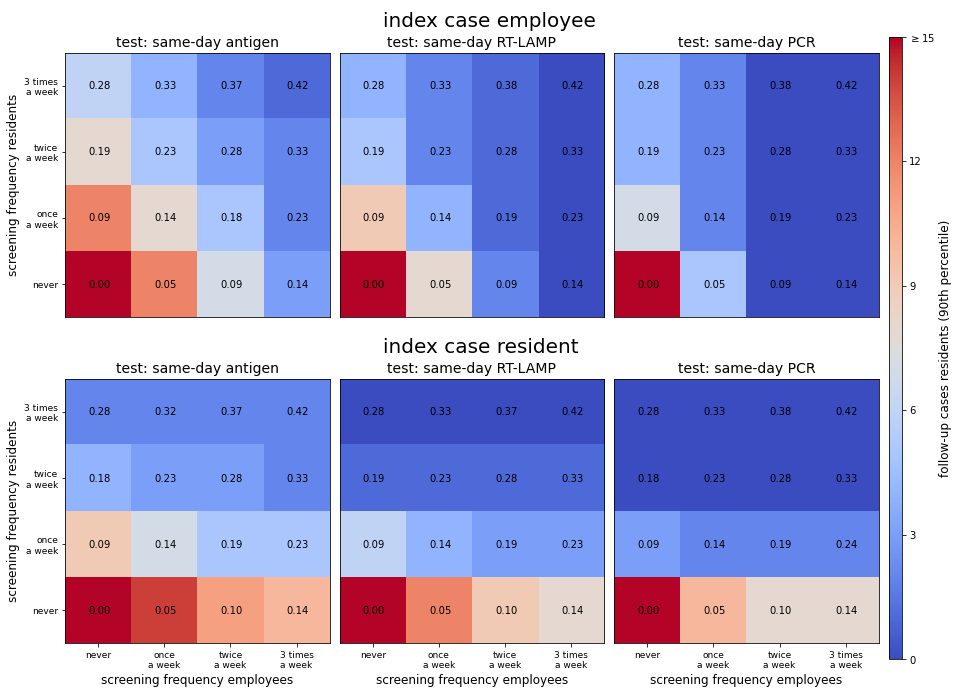

In [85]:
metric = 'infected_residents_0.90'
sim_name = 'simulation_results'
screening_params = screening_intervals
xlabel = 'screening frequency employees'
ylabel = 'screening frequency residents'

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin=0
vmax=15
vstep=3

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # remove all axis labels and ticks for the heatmaps
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
        
    j = 0
    # compare same-day turnover testing for different testing technologies
    for j, ax, test_type in zip(range(3), hmap_axes[i],\
                       ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']):
        
        # set flag to set axis ticks only for heatmaps at the boundaries of 
        # the figure
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the testing technology in the heatmap title
        ax.set_title('test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df, test_type, screening_params, metric)
        if index_case_mode == 'resident':
            # if a resident is the index case, we need to subtract 1 from the
            # number of infected residents, to calculate the "outbreak size",
            # which is defined as the number of FOLLOW-UP cases, given an index
            # case
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax,
                                   xticks, yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df, test_type, screening_params, 
                                    'test_rate_mean')
        af.annotate_heatmap(ax, test_rate)
        
# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                        ticks=np.arange(vmin, vmax + 1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 'screening_frequency_test_technology.png'), dpi=300, 
            transparent=True)
plt.savefig(join(dst_path, 'screening_frequency_test_technology.pdf'))

## PCR: different turnover times

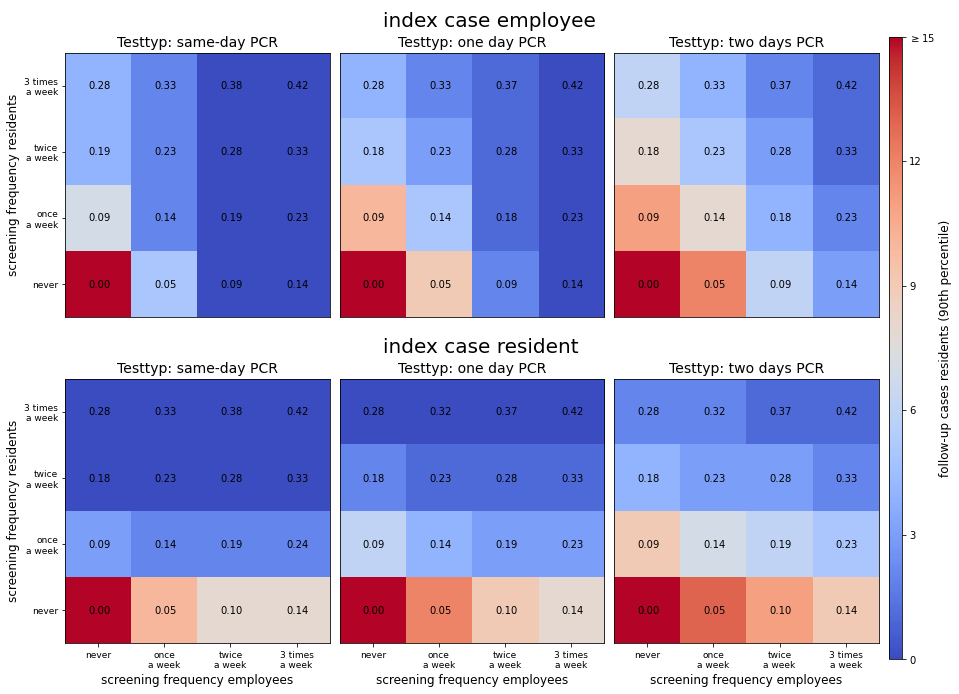

In [86]:
metric = 'infected_residents_0.90'
sim_name = 'simulation_results'
screening_params = screening_intervals
xlabel = 'screening frequency employees'
ylabel = 'screening frequency residents'

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 15
vstep = 3

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # set flag to set axis ticks only for heatmaps at the boundaries of 
    # the figure
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
    
    # compare different test result turnover times for PCR tests
    for j, ax, test_type in zip(range(3), hmap_axes[i], \
                        ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']):
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the turnover time in the heatmap title
        ax.set_title('Testtyp: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df, test_type, screening_params, metric)
        if index_case_mode == 'resident':
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax,
                                   xticks, yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df, test_type, screening_params, 
                                    'test_rate_mean')
        af.annotate_heatmap(ax, test_rate)

# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                ticks=np.arange(vmin, vmax+1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 'screening_frequency_PCR_turnover_time.png'), dpi=300, 
            transparent=True)
plt.savefig(join(dst_path, 'screening_frequency_PCR_turnover_time.pdf'))

## Number of agents infected by the index case

In [87]:
# all ensembles that had no preventive testing in place (the test technology
# does not make a difference, because it is only used for potential preventive
# tests anyways)
no_measures = data.loc[:,'never', 'never'].copy().reset_index()
nm_residents = no_measures[no_measures['index_case'] == 'resident']
nm_employees = no_measures[no_measures['index_case'] == 'employee']

In [88]:
print('index case resident: R = {:1.4f} +- {:1.4f}'\
      .format(nm_residents['R0_mean'].mean(), nm_residents['R0_std'].mean()))
print('index case employee: R = {:1.4f} +- {:1.4f}'\
      .format(nm_employees['R0_mean'].mean(), nm_employees['R0_std'].mean()))

index case resident: R = 1.3539 +- 1.5030
index case employee: R = 1.2921 +- 1.4382


## Outbreak sizes

**Note**: for resident index cases, the index case needs to be subtracted from the outbreak size

### Minimum and maximum

In [89]:
nm_residents['infected_residents_0.10'] - 1

1    0.0
3    0.0
5    0.0
7    0.0
9    0.0
Name: infected_residents_0.10, dtype: float64

In [90]:
nm_residents['infected_residents_median'] - 1

1    1.0
3    1.0
5    1.0
7    1.0
9    1.0
Name: infected_residents_median, dtype: float64

In [91]:
nm_residents['infected_residents_0.90'] - 1

1    16.0
3    16.0
5    16.0
7    17.0
9    16.0
Name: infected_residents_0.90, dtype: float64

In [92]:
nm_employees['infected_residents_0.10']

0    0.0
2    0.0
4    0.0
6    0.0
8    0.0
Name: infected_residents_0.10, dtype: float64

In [93]:
nm_employees['infected_residents_median']

0    1.0
2    1.0
4    1.0
6    1.0
8    1.0
Name: infected_residents_median, dtype: float64

In [94]:
nm_employees['infected_residents_0.90']

0    17.0
2    17.0
4    16.0
6    17.0
8    17.0
Name: infected_residents_0.90, dtype: float64

### Realistic scenario I: employees screened 2x / week

#### Same-day Antigen

In [95]:
data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_0.90']

7.0

In [96]:
data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_0.90'] - 1

11.0

#### Same-day LAMP

In [97]:
data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_0.90']

2.0

In [98]:
data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_0.90'] - 1

9.0

#### One-day PCR

In [99]:
data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_0.90']

2.0

In [100]:
data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_0.90'] - 1

9.0

#### Same-day PCR

In [101]:
data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_0.90']

0.0

In [102]:
data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_0.90'] - 1

8.0

#### Two-day PCR

In [103]:
data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_0.90']

6.0

In [104]:
data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_0.90'] - 1

11.0

### Realistic scenario II: employees screened 1x / week

#### Same-day Antigen

In [105]:
data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_0.90']

12.0

In [106]:
data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_0.90'] - 1

14.0

#### Same-day LAMP

In [107]:
data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_0.90']

8.0

In [108]:
data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_0.90'] - 1

12.0

#### Same-day PCR

In [109]:
data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_0.90']

5.0

In [110]:
data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_0.90'] - 1

10.0

### Two-day PCR

In [111]:
data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_0.90']

3.0

In [112]:
data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_0.90'] - 1

9.0

In [113]:
data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_0.90']

2.0

In [114]:
data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_0.90'] - 1

5.0

In [115]:
data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_0.90']

1.0

In [116]:
data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_0.90'] - 1

2.0

In [117]:
data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_0.90']

1.0

In [118]:
data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_0.90'] - 1

1.0

### Same-day PCR

In [119]:
data.loc['same_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_0.90']

0.0

In [120]:
data.loc['same_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_0.90'] - 1

8.0

In [121]:
data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_0.90']

2.0

In [122]:
data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_0.90'] - 1

2.0

## Test rates

### Diagnostic testing base rate

In [123]:
data.loc[:, 'never', 'never', :]['test_rate_mean'].mean()

0.00384403918343115

In [124]:
data.loc[:, 'never', 'never', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.003238
                  resident      0.003095
same_day_LAMP     employee      0.003183
                  resident      0.003138
same_day_PCR      employee      0.003110
                  resident      0.003107
one_day_PCR       employee      0.003168
                  resident      0.003209
two_day_PCR       employee      0.003153
                  resident      0.003115
Name: test_rate_std, dtype: float64

### Test rates employeed screened 2x / week

In [125]:
data.loc[:, 'twice\na week', 'never', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.093707
                  resident      0.096077
same_day_LAMP     employee      0.094168
                  resident      0.096021
same_day_PCR      employee      0.093965
                  resident      0.096239
one_day_PCR       employee      0.093652
                  resident      0.095733
two_day_PCR       employee      0.093265
                  resident      0.095109
Name: test_rate_mean, dtype: float64

In [126]:
data.loc[:, 'twice\na week', 'never', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.010428
                  resident      0.009697
same_day_LAMP     employee      0.011639
                  resident      0.009671
same_day_PCR      employee      0.012264
                  resident      0.009419
one_day_PCR       employee      0.011442
                  resident      0.009896
two_day_PCR       employee      0.010906
                  resident      0.009994
Name: test_rate_std, dtype: float64

### Test rates residents screened 2x / week

In [127]:
data.loc[:, 'never', 'twice\na week', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.185081
                  resident      0.183678
same_day_LAMP     employee      0.185649
                  resident      0.185242
same_day_PCR      employee      0.186095
                  resident      0.184218
one_day_PCR       employee      0.184735
                  resident      0.183843
two_day_PCR       employee      0.183925
                  resident      0.183038
Name: test_rate_mean, dtype: float64

In [62]:
data.loc[:, 'never', 'twice\na week', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.018572
                  resident      0.020855
same_day_LAMP     employee      0.018772
                  resident      0.022342
same_day_PCR      employee      0.018268
                  resident      0.023927
one_day_PCR       employee      0.018202
                  resident      0.022332
two_day_PCR       employee      0.018911
                  resident      0.021317
Name: test_rate_std, dtype: float64

### Test rates residents screened 3x / week

In [66]:
data.loc[:, 'never', '3 times\na week', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.278607
                  resident      0.277456
same_day_LAMP     employee      0.279042
                  resident      0.278762
same_day_PCR      employee      0.278889
                  resident      0.278074
one_day_PCR       employee      0.278737
                  resident      0.277923
two_day_PCR       employee      0.277242
                  resident      0.275976
Name: test_rate_mean, dtype: float64

In [67]:
data.loc[:, 'never', '3 times\na week', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.019798
                  resident      0.021322
same_day_LAMP     employee      0.018826
                  resident      0.023012
same_day_PCR      employee      0.019188
                  resident      0.023890
one_day_PCR       employee      0.019365
                  resident      0.023577
two_day_PCR       employee      0.019812
                  resident      0.022298
Name: test_rate_std, dtype: float64

## Results table

In [16]:
table_data = data.loc[:,:,:,'employee']

In [17]:
table_cols = ['infected_residents_mean', 'infected_residents_std',
              'infected_residents_median', 'infected_residents_0.10',
              'infected_residents_0.90', 'R0_mean', 'R0_std', 'test_rate_mean', 'test_rate_std']
table_data = table_data.loc[:, :, ['never', 'once\na week']][table_cols]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])
table_data.to_csv(join(res_path, 'table_testing_strategy.csv'))

## Preventive testing rates

In [21]:
data.loc[:,'3 times\na week', 'never', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.141155       0.011407
                 resident          0.143425       0.010600
same_day_LAMP    employee          0.141584       0.012203
                 resident          0.143605       0.010401
same_day_PCR     employee          0.141158       0.012130
                 resident          0.143378       0.010307
one_day_PCR      employee          0.140800       0.011991
                 resident          0.143477       0.010729
two_day_PCR      employee          0.139678       0.011647
                 resident          0.142416       0.011136

In [22]:
data.loc[:,'never', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.278607       0.019798
                 resident          0.277456       0.021322
same_day_LAMP    employee          0.279042       0.018826
                 resident          0.278762       0.023012
same_day_PCR     employee          0.278889       0.019188
                 resident          0.278074       0.023890
one_day_PCR      employee          0.278737       0.019365
                 resident          0.277923       0.023577
two_day_PCR      employee          0.277242       0.019812
                 resident          0.275976       0.022298

In [23]:
data.loc[:,'3 times\na week', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.421883       0.032013
                 resident          0.422001       0.032464
same_day_LAMP    employee          0.423431       0.035060
                 resident          0.423250       0.035601
same_day_PCR     employee          0.422934       0.036567
                 resident          0.423312       0.035929
one_day_PCR      employee          0.422947       0.035773
                 resident          0.422924       0.035489
two_day_PCR      employee          0.420640       0.032849
                 resident          0.421338       0.033812